In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import inspect
import logging
import os
import pandas as pd
from csrank.util import setup_logging, print_dictionary
from result_script import *

from csrank.experiments import CHOICE_FUNCTIONS, CHOICE_MODELS
from csrank.constants import CHOICE_FUNCTION
import numpy as np

Using TensorFlow backend.
/home/prithagupta/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results_choice.log')
FOLDER = "journalresults"
latex_path = os.path.join(DIR_PATH, FOLDER, 'choice_functions.tex')
df_path_combined = os.path.join(DIR_PATH, FOLDER , "ChoiceFunctions.csv")

setup_logging(log_path=log_path, level=logging.ERROR)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_choice', 'mnist_choice', 'letor_choice', 'exp_choice']

learning_problem = CHOICE_FUNCTION
learning_model =  learners_map[learning_problem]
models_dict = dict(zip(CHOICE_FUNCTIONS, CHOICE_MODELS))

In [3]:
import re
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]]
    return x
def create_final_result(dataset, dataset_function=get_combined_results ,latex_row=False):
    df_full = dataset_function(dataset, logger, learning_problem, latex_row=latex_row)
    data = []
    for dataset, df in df_full.groupby(['Dataset']):
        for m in CHOICE_FUNCTIONS:
            row = df[df[learning_model].str.contains(m)].values
            onerow = None
            if len(row) > 1:
                if dataset_function==get_combined_results:
                    values = np.array([get_val(val[2]) for val in row])
                else:
                    values = np.array([[val[2], val[2] - val[7]] for val in row])
                maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0][0]
                logger.error("dataset {} model {}, vals {}, maxi {}".format(dataset, row[:, 1], values, maxi))
                row = row[maxi]
                row[1] = models_dict[m]
                onerow = row

            elif len(row)==1:
                row[0][1] = models_dict[m]
                onerow = row[0]
            if onerow is not None:
                onerow[0] = get_dataset_name(onerow[0])
                data.append(onerow)
    columns = df_full.columns
    dataframe = pd.DataFrame(data, columns=columns)
    dataframe = dataframe.sort_values(by=[columns[0], columns[2]], ascending=[True, False])
    return dataframe

In [4]:
d = datasets[0]
df = create_final_result(d, latex_row=False)
df

,Dataset,ChoiceModel,$F_1$Measure,Precision,Recall,Subset $0/1$ Accuracy,HammingAccuracy,Informedness,AUC-Score,AveragePrecisionScore
0,Pareto-front,FETA-Net,0.942±0.008,0.938±0.007,0.967±0.013,0.680±0.028,0.985±0.002,0.956±0.012,0.999±0.000,0.996±0.000
1,Pareto-front,FATE-Net,0.912±0.009,0.919±0.015,0.926±0.005,0.506±0.037,0.975±0.003,0.911±0.006,0.996±0.001,0.984±0.003
2,Pareto-front,FETA-Linear,0.673±0.001,0.697±0.023,0.748±0.023,0.064±0.007,0.913±0.003,0.694±0.015,0.955±0.000,0.865±0.000
3,Pareto-front,FATE-Linear,0.673±0.000,0.683±0.019,0.761±0.018,0.059±0.005,0.911±0.003,0.704±0.012,0.955±0.000,0.865±0.000
4,Pareto-front,RankNet-Choice,0.612±0.007,0.624±0.026,0.772±0.029,0.060±0.010,0.877±0.011,0.672±0.014,0.971±0.006,0.891±0.019
5,Pareto-front,PairwiseSVM,0.588±0.001,0.596±0.012,0.756±0.015,0.044±0.003,0.866±0.005,0.646±0.007,0.956±0.000,0.865±0.000
6,Pareto-front,GeneralizedLinearModel,0.585±0.008,0.604±0.022,0.738±0.023,0.044±0.005,0.869±0.009,0.633±0.013,0.952±0.007,0.861±0.011
7,Pareto-front,AllPositive,0.232±0.000,0.133±0.000,1.000±0.000,0.000±0.000,0.133±0.000,0.000±0.000,0.500±0.000,0.133±0.000


In [5]:
import copy
from csrank.experiments.constants import RANDOM_CHOICE
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, get_combined_results_plot ,latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
searchFor = ["5 Objects", "Critique"]
df = dataFrame[~dataFrame.Dataset.str.contains('|'.join(searchFor))]
df.replace(to_replace=r' 10 Objects', value='', regex=True, inplace=True)
df.replace(to_replace=r'LETOR ', value='LETOR\n', regex=True, inplace=True)
df.Dataset.unique(), df[learning_model].unique()

(array(['Pareto-front', 'Mode', 'Unique', 'LETOR\nMQ2007', 'LETOR\nMQ2008',
        'Expedia'], dtype=object),
 array(['FETA-Net', 'FATE-Net', 'FATE-Linear', 'FETA-Linear',
        'RankNet-Choice', 'PairwiseSVM', 'GeneralizedLinearModel',
        'AllPositive'], dtype=object))

<IPython.core.display.Javascript object>


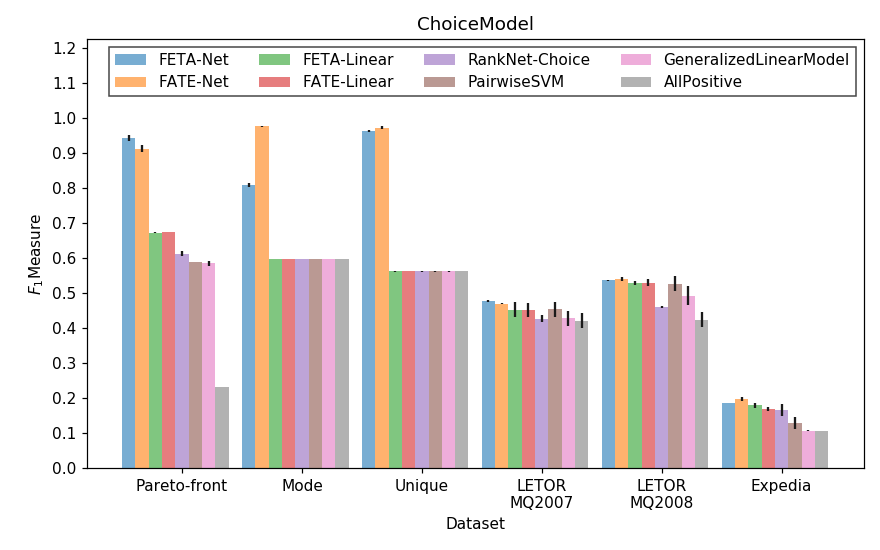

In [6]:
from csrank.constants import DISCRETE_CHOICE
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
# create plot
extension = 'pdf'
fname = os.path.join(DIR_PATH, FOLDER, "{}_{}.{}")
start = 0.0
ncols = 4
plts = bar_plot_for_problem(df, learning_problem, start, ncols, fname, extension)

In [7]:
import copy
dataFrame = None
for dataset in datasets:
    df = create_final_result(dataset, latex_row=False)
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(df_path_combined)
dataFrame

,Dataset,ChoiceModel,$F_1$Measure,Precision,Recall,Subset $0/1$ Accuracy,HammingAccuracy,Informedness,AUC-Score,AveragePrecisionScore
0,Pareto-front,FETA-Net,0.942±0.008,0.938±0.007,0.967±0.013,0.680±0.028,0.985±0.002,0.956±0.012,0.999±0.000,0.996±0.000
1,Pareto-front,FATE-Net,0.912±0.009,0.919±0.015,0.926±0.005,0.506±0.037,0.975±0.003,0.911±0.006,0.996±0.001,0.984±0.003
2,Pareto-front,FETA-Linear,0.673±0.001,0.697±0.023,0.748±0.023,0.064±0.007,0.913±0.003,0.694±0.015,0.955±0.000,0.865±0.000
3,Pareto-front,FATE-Linear,0.673±0.000,0.683±0.019,0.761±0.018,0.059±0.005,0.911±0.003,0.704±0.012,0.955±0.000,0.865±0.000
4,Pareto-front,RankNet-Choice,0.612±0.007,0.624±0.026,0.772±0.029,0.060±0.010,0.877±0.011,0.672±0.014,0.971±0.006,0.891±0.019
5,Pareto-front,PairwiseSVM,0.588±0.001,0.596±0.012,0.756±0.015,0.044±0.003,0.866±0.005,0.646±0.007,0.956±0.000,0.865±0.000
6,Pareto-front,GeneralizedLinearModel,0.585±0.008,0.604±0.022,0.738±0.023,0.044±0.005,0.869±0.009,0.633±0.013,0.952±0.007,0.861±0.011
7,Pareto-front,AllPositive,0.232±0.000,0.133±0.000,1.000±0.000,0.000±0.000,0.133±0.000,0.000±0.000,0.500±0.000,0.133±0.000
8,Mode,FATE-Net,0.976±0.001,0.980±0.003,0.979±0.004,0.883±0.011,0.978±0.001,0.961±0.002,0.992±0.001,0.991±0.002
9,Mode,FETA-Net,0.809±0.005,0.742±0.003,0.962±0.009,0.311±0.032,0.809±0.004,0.695±0.009,0.981±0.006,0.980±0.006


In [8]:
import string
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    if len(vals)==1:
        x = [vals[0], vals[0]-0.0]
    else:
        x = [vals[0], vals[0] - vals[1]*1e-3]
    return x
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[[learning_model, col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df[learning_model] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [9]:
import re

def create_latex(df):
    grouped = df.groupby(['Dataset'])
    code = ""
    for name, group in grouped:
        print("############################################################################")
        print("Dataset {}\n".format(name))
        code = code + "\n\t\tName {} \t\t\n\n".format(name)
        custom_dict = dict()
        for i, m in enumerate(CHOICE_MODELS):
            custom_dict[m] = i
        group['rank'] = group[learning_model].map(custom_dict)
        group.sort_values(by='rank', inplace=True)
        del group["Dataset"]
        del group['rank']
        group = mark_best(group)
        group[learning_model].replace(to_replace=['GeneralizedLinearModel'], value='glm',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Net'], value='fatenet',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Net'], value='fetanet',inplace=True)
        group[learning_model].replace(to_replace=['RankNet-Choice'], value='ranknet',inplace=True)
        group[learning_model].replace(to_replace=['PairwiseSVM'], value='pairwisesvm',inplace=True)
        group[learning_model].replace(to_replace=['AllPositive'], value='allpositive',inplace=True)
        group[learning_model].replace(to_replace=['FATE-Linear'], value='fatelinear',inplace=True)
        group[learning_model].replace(to_replace=['FETA-Linear'], value='fetalinear',inplace=True)
        del group['HammingAccuracy']
        del group['Precision']
        del group['Recall']
        del group['AveragePrecisionScore']
        latex_code = group.to_latex(index = False)
        latex_code = latex_code.replace(' ',"")
        latex_code = latex_code.replace('&'," & ")
        latex_code = str(latex_code)
        for learner in group[learning_model]:
            latex_code = latex_code.replace(learner, "\\{}".format(learner))
        latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
        latex_code = latex_code.replace("\\$", "$")
        latex_code = latex_code.replace("\\_", "_")
        code = code + latex_code
    return code
code = ""
for dataset in datasets:
    df = create_final_result(dataset, latex_row=True)
    df.sort_values(by='Dataset')
    code = code + create_latex(df)
f= open(latex_path,"w+")
f.write(code)
f.close()

############################################################################
Dataset Pareto-front

############################################################################
Dataset Mode

############################################################################
Dataset Unique

############################################################################
Dataset LETOR MQ2007 10 Objects

############################################################################
Dataset LETOR MQ2007 5 Objects

############################################################################
Dataset LETOR MQ2008 10 Objects

############################################################################
Dataset LETOR MQ2008 5 Objects

############################################################################
Dataset Expedia 10 Objects



In [10]:
"UNIQUE_MAX_OCCURRING".lower()

'unique_max_occurring'